In [90]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [91]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
from visualization.visualization import draw_BN
from gmr import GMM
from scipy import stats
from sklearn.datasets import make_spd_matrix

In [64]:
bn = dict()
bn['V'] = ['D1', 'D2', 'N1', 'N2', 'N3']
bn['E'] = [['N1', 'N3'], ['N1', 'N2'], ['D2', 'N2'], ['D2', 'N1'], ['D1', 'N1']]

In [92]:
node_types = {'D1':'disc', 'D2': 'disc', 'N1': 'cont', 'N2': 'cont', 'N3': 'cont'}

In [65]:
n1 = 2
x1 = np.arange(n1)
p1 = tuple(np.random.dirichlet(np.ones(n1),size=1)[0])
custm1 = stats.rv_discrete(name='custm1', values=(x1, p1))

In [66]:
n2 = 4
x2 = np.arange(n2)
p2 = tuple(np.random.dirichlet(np.ones(n2),size=1)[0])
custm2 = stats.rv_discrete(name='custm2', values=(x2, p2))

In [67]:
mean = dict()
cov = dict()
for i in x1:
    for j in x2:
        n = random.randint(2,4)
        means = []
        covs = []
        for _ in range(n):
            means.append([random.randint(-1000, 1000), random.randint(-1000, 1000), random.randint(-1000, 1000)])
            covs.append(make_spd_matrix(3))
        mean[str(i)+str(j)] = means
        cov[str(i)+str(j)] = covs


In [68]:
df = pd.DataFrame(columns=['D1', 'D2', 'N1', 'N2', 'N3'])
df['D1'] = custm1.rvs(size=3000)
df['D2'] = custm2.rvs(size=3000)

In [70]:
df_new = pd.DataFrame()
for i in x1:
    for j in x2:
        sample = df.loc[(df['D1'] == i) & (df['D2'] == j)]
        size = sample.shape[0]
        means = mean[str(i)+str(j)]
        covs = cov[str(i)+str(j)]
        n = len(means)
        model = GMM(n_components=n, priors=[1/n for _ in range(n)], means=means, covariances=covs)
        cont_data = model.sample(size)
        sample[['N1', 'N2', 'N3']] = cont_data
        df_new = pd.concat([df_new, sample])
df_new.reset_index(inplace=True, drop=True)

<ipython-input-70-27497bb46744>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[['N1', 'N2', 'N3']] = cont_data
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-70-27497bb46744>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='N1', ylabel='N3'>

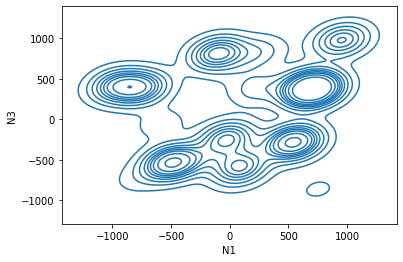

In [88]:
sns.kdeplot(df_new['N1'], df_new['N3'])